In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import h5py
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from ModuleLibrary.metrics import MCC, BA
from ModuleLibrary.utils import sliding_window_view

2022-04-20 15:53:46.503888: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# Gestion du padding
def padding_slidding(input, kernel):
    arr = np.append(np.zeros(((kernel // 2) + ((kernel % 2) - 1),input.shape[1])), input, axis=0) 
    arr = np.append(arr, np.zeros((kernel//2,input.shape[1])), axis=0)
    arr = sliding_window_view(arr, kernel, axis=0)
    output = arr.flatten(order='K').reshape((input.shape[0],kernel,input.shape[1]))
    return output

# Fenêtre glissante
def sliding_window_view(x, window_shape, axis=None, *, subok=False, writeable=False):
    '''
    Takes an numpy array and a window size and return a vectorized
    sliding window. 
    '''
    window_shape = (tuple(window_shape)
                    if np.iterable(window_shape)
                    else (window_shape,))
    # first convert input to array, possibly keeping subclass
    x = np.array(x, copy=False, subok=subok)

    window_shape_array = np.array(window_shape)
    if np.any(window_shape_array < 0):
        raise ValueError('`window_shape` cannot contain negative values')

    if axis is None:
        axis = tuple(range(x.ndim))
        if len(window_shape) != len(axis):
            raise ValueError(f'Since axis is `None`, must provide '
                             f'window_shape for all dimensions of `x`; '
                             f'got {len(window_shape)} window_shape elements '
                             f'and `x.ndim` is {x.ndim}.')
    else:
        axis = np.core.numeric.normalize_axis_tuple(axis, x.ndim, allow_duplicate=True)
        if len(window_shape) != len(axis):
            raise ValueError(f'Must provide matching length window_shape and '
                             f'axis; got {len(window_shape)} window_shape '
                             f'elements and {len(axis)} axes elements.')

    out_strides = x.strides + tuple(x.strides[ax] for ax in axis)

    # note: same axis can be windowed repeatedly
    x_shape_trimmed = list(x.shape)
    for ax, dim in zip(axis, window_shape):
        if x_shape_trimmed[ax] < dim:
            raise ValueError(
                'window shape cannot be larger than input array shape')
        x_shape_trimmed[ax] -= dim - 1
    out_shape = tuple(x_shape_trimmed) + window_shape
    return np.lib.stride_tricks.as_strided(x, strides=out_strides, shape=out_shape,
                      subok=subok, writeable=writeable)

In [11]:
class Features_exploration():

    def __init__(self, model_path):
        self.model = load_model(model_path, custom_objects={'MCC': MCC, 'BA' : BA})
        self.model_w = h5py.File(model_path,'r')
        self.load_weights()

    def load_weights(self):
        # Layers
        self.conv1 = Model(inputs=self.model.inputs, outputs=self.model.get_layer(name="conv2d").output) 
        self.mp1 = Model(inputs=self.model.inputs, outputs=self.model.get_layer(name="max_pooling2d").output)
        self.conv2 = Model(inputs=self.model.inputs, outputs=self.model.get_layer(name="conv2d_1").output) 
        self.mp2 = Model(inputs=self.model.inputs, outputs=self.model.get_layer(name="max_pooling2d_1").output)
        self.conv3 = Model(inputs=self.model.inputs, outputs=self.model.get_layer(name="conv2d_2").output) 
        self.mp3 = Model(inputs=self.model.inputs, outputs=self.model.get_layer(name="max_pooling2d_2").output)
        self.flatten = Model(inputs=self.model.inputs, outputs=self.model.get_layer(name="flatten").output)
        self.d1 = Model(inputs=self.model.inputs, outputs=self.model.get_layer(name="dense").output)
        self.d2 = Model(inputs=self.model.inputs, outputs=self.model.get_layer(name="dense_1").output)

        # Layers weights
        self.conv1_w = np.reshape(np.array(self.model_w['model_weights']['conv2d']['conv2d']['kernel:0']), (6,4,32)) 
        self.conv2_w = np.reshape(np.array(self.model_w['model_weights']['conv2d_1']['conv2d_1']['kernel:0']), (6,32,64)) 
        self.conv3_w = np.reshape(np.array(self.model_w['model_weights']['conv2d_2']['conv2d_2']['kernel:0']), (6,64,128))
        self.d1_w = np.array(self.model_w['model_weights']['dense']['dense']['kernel:0']) # (4736,128)
        self.d2_w = np.reshape(np.array(self.model_w['model_weights']['dense_1']['dense_1']['kernel:0']), (128)) 

        # Layers bias
        self.conv1_b = np.array(self.model_w['model_weights']['conv2d']['conv2d']['bias:0']) # (32)
        self.conv2_b = np.array(self.model_w['model_weights']['conv2d_1']['conv2d_1']['bias:0']) # (64)
        self.conv3_b = np.array(self.model_w['model_weights']['conv2d_2']['conv2d_2']['bias:0']) # (128)
        self.d1_b = np.array(self.model_w['model_weights']['dense']['dense']['bias:0']) # (128)
        self.d2_b = np.array(self.model_w['model_weights']['dense_1']['dense_1']['bias:0']) # (1)

    def explore(self, data):
        
        # Input reshape
        data = data.reshape(1,data.shape[0], data.shape[1],1)

        # Layers output
        conv1_output = np.reshape(self.conv1.predict(data), (296,32))
        mp1_output = np.reshape(self.mp1.predict(data), (148,32))
        conv2_output = np.reshape(self.conv2.predict(data), (148,64))
        mp2_output = np.reshape(self.mp2.predict(data), (74,64))
        conv3_output = np.reshape(self.conv3.predict(data), (74,128))
        mp3_output = np.reshape(self.mp3.predict(data), (37,128))
        flatten_output = np.reshape(self.flatten.predict(data), (4736))
        d1_output = np.reshape(self.d1.predict(data), (128))
        d2_output = np.reshape(self.d2.predict(data), (1))

        print(f'Input prediction : {round(d2_output[0],5)}')
##################################################################################################################
        # Dense 2 
        d1_output_contrib = np.zeros(d1_output.shape) # (128)
        for i in range(d1_output.shape[0]):
            d1_output_contrib[i] = d1_output[i] * self.d2_w[i]

##################################################################################################################        
        # Dense 1
        flatten_output_contrib = np.zeros(flatten_output.shape) # (4736)
        for i in range(flatten_output.shape[0]):
            for j in range(self.d1_w.shape[1]): 
                x = flatten_output[i] * self.d1_w[i][j] * d1_output_contrib[j]
                if d1_output[j] > 0:
                    flatten_output_contrib[i] += x
                else:
                    flatten_output_contrib[i] += -x

##################################################################################################################
        # Unflatten
        mp3_output_contrib = flatten_output_contrib.reshape((mp3_output.shape[0], mp3_output.shape[1])) # (37, 128)

##################################################################################################################
        # Unmaxpooling 1 
        conv3_output_contrib = np.zeros((conv3_output.shape[0],conv3_output.shape[1])) # (74, 128)
        for i in range(0,conv3_output.shape[0],2):
            for j in range(conv3_output.shape[1]):
                if conv3_output[i][j] > conv3_output[i+1][j]:
                    conv3_output_contrib[i][j] = mp3_output_contrib[int(i/2)][j]
                else:
                    conv3_output_contrib[i+1][j] = mp3_output_contrib[int(i/2)][j]

##################################################################################################################
        # Conv3
        mp2_output_contrib = np.zeros((mp2_output.shape[0],mp2_output.shape[1])) # (74, 64)
        mp2_output_reshaped = padding_slidding(mp2_output,6) #(74, 6, 64)
        for i, eli in enumerate(mp2_output_reshaped): # 74
            for l in range(conv3_output.shape[1]): # 128
                for j, elj in enumerate(eli): # 6
                    for k, elk in enumerate(elj): # 64
                        x = elk * self.conv3_w[j][k][l] * conv3_output_contrib[i][l]
                        if conv3_output[i][l] > 0:
                            mp2_output_contrib[i][k] += x
                        else:
                            mp2_output_contrib[i][k] += -x

##################################################################################################################
        # Unmaxpooling 2 
        conv2_output_contrib = np.zeros((conv2_output.shape[0],conv2_output.shape[1])) # (148, 64)
        for i in range(0,conv2_output.shape[0],2):
            for j in range(conv2_output.shape[1]):
                if conv2_output[i][j] > conv2_output[i+1][j]:
                    conv2_output_contrib[i][j] = mp2_output_contrib[int(i/2)][j]
                else:
                    conv2_output_contrib[i+1][j] = mp2_output_contrib[int(i/2)][j]

##################################################################################################################
        # Conv2
        mp1_output_contrib = np.zeros((mp1_output.shape[0], mp1_output.shape[1])) # (148, 32)
        mp1_output_reshaped = padding_slidding(mp1_output,6) # (148, 6, 32)
        for i, eli in enumerate(mp1_output_reshaped): # 148
            for l in range(conv2_output.shape[1]): # 64
                for j, elj in enumerate(eli): # 6
                    for k, elk in enumerate(elj): # 32
                        x = elk * self.conv2_w[j][k][l] * conv2_output_contrib[i][l]
                        if conv2_output[i][l] > 0:
                            mp1_output_contrib[i][k] += x
                        else:
                            mp1_output_contrib[i][k] += -x

##################################################################################################################
        # Unmaxpooling 3 
        conv1_output_contrib = np.zeros((conv1_output.shape[0], conv1_output.shape[1]))
        for i in range(0,conv1_output.shape[0],2):
            for j in range(conv1_output.shape[1]):
                if conv1_output[i][j] > conv1_output[i+1][j]:
                    conv1_output_contrib[i][j] = mp1_output_contrib[int(i/2)][j]
                else:
                    conv1_output_contrib[i+1][j] = mp1_output_contrib[int(i/2)][j]

##################################################################################################################        
        # Conv1
        seq = data.reshape(data.shape[1], data.shape[2])
        seq = sliding_window_view(seq, 6, axis=0)
        seq = seq.flatten(order='K').reshape((seq.shape[0],seq.shape[2],seq.shape[1]))
        seq_contrib = np.zeros((data.shape[1],data.shape[2]))

        for i, eli in enumerate(seq): # 296
            for l in range(conv1_output.shape[1]): # 32
                for j, elj in enumerate(eli): # 6
                    for k, elk in enumerate(elj): # 4
                        x = elk * self.conv1_w[j][k][l] * conv1_output_contrib[i][l]
                        if conv1_output[i][l] > 0:
                            seq_contrib[i+j][k] += x
                        else:
                            seq_contrib[i+j][k] += -x

        maxvalue = max(float(np.max(seq_contrib)),float(-np.min(seq_contrib)))
        for i in range(len(seq_contrib)):
            for j in range(4):
                seq_contrib[i][j] = seq_contrib[i][j] / maxvalue
        
        seq_contrib = np.transpose(seq_contrib)
##################################################################################################################
        # Plotting

        # Custom color bar pour la heat map (enlever cmap=cmap pour retirer)
        cim = plt.imread("ModuleLibrary/colorbar.png")
        cim = cim[cim.shape[0]//2, 50:390, :]
        cmap = mcolors.ListedColormap(cim)

        
        plt.figure(figsize=(34,1), dpi= 200)
        plt.imshow(seq_contrib, cmap=cmap, aspect='auto', vmin=-1, vmax=1)
        plt.xticks(np.arange(0, 301,10))
        plt.yticks([0,1,2,3], ['a','t','g','c'])
        plt.colorbar()
        plt.show()

## Exemple d'utilisation

Input prediction : 1.9999999494757503e-05


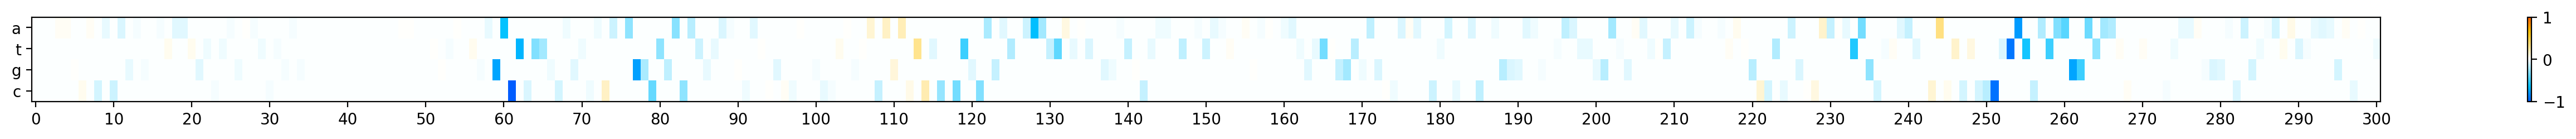

In [12]:
model_path = 'Results/newHS37_exon_start/best_metrics_model.hdf5'

# Chargement du modèle et des poids
exemple = Features_exploration(model_path)

# Chargement de l'input (en one_hot)
data = np.load(f'Data/DNA/HS37/one_hot/chr1.npy').astype('int8')
data = data[100000:100301] # shape = (301,4)

# Motif exploration (Retourne la prediction et une heatmap de la contribution de chaque pb)
# /!\ Beaucoup de warnings de keras à la première utilisation /!\
exemple.explore(data)